In [129]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [130]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.keras'

# 分類数設定

In [131]:
NUM_CLASSES = 7

# 入力長

In [132]:
TIME_STEPS = 16
DIMENSION = 3

# 学習データ読み込み

In [133]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [134]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [136]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [137]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │            77 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,503 (5.87 KB)

 Trainable params: 1,503 (5.87 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [139]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [140]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
43/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2964 - loss: 1.9335   
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3243 - loss: 1.9224 - val_accuracy: 0.5501 - val_loss: 1.8346
Epoch 2/1000
73/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4503 - loss: 1.8009
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4520 - loss: 1.7968 - val_accuracy: 0.5794 - val_loss: 1.6223
Epoch 3/1000
47/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5204 - loss: 1.6121 
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5223 - loss: 1.5908 - val_accuracy: 0.5919 - val_loss: 1.3851
Epoch 4/1000
74/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5615 - loss: 1.3896
Epoch 4: saving model to model/point_history_c

In [141]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [142]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
[1.8036926e-01 5.8334786e-06 8.0963469e-01 2.1543107e-03 4.4125281e-03
 9.3750481e-05 3.3295681e-03]
2


# 混同行列

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


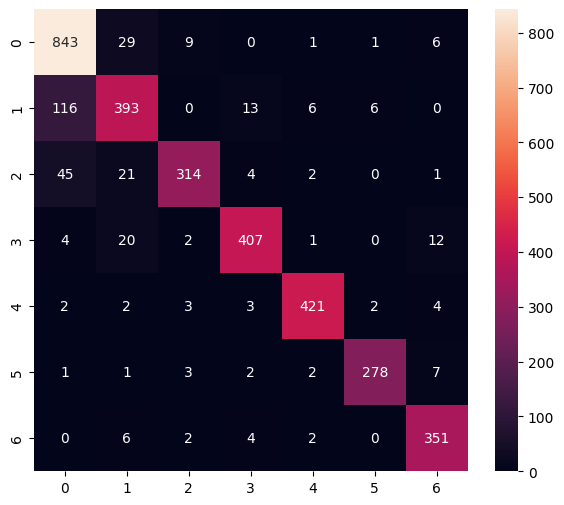

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       889
           1       0.83      0.74      0.78       534
           2       0.94      0.81      0.87       387
           3       0.94      0.91      0.93       446
           4       0.97      0.96      0.97       437
           5       0.97      0.95      0.96       294
           6       0.92      0.96      0.94       365

    accuracy                           0.90      3352
   macro avg       0.92      0.90      0.90      3352
weighted avg       0.90      0.90      0.90      3352



In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [144]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [145]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [146]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ARTHUR~1\AppData\Local\Temp\tmpczq5ks4t\assets


INFO:tensorflow:Assets written to: C:\Users\ARTHUR~1\AppData\Local\Temp\tmpczq5ks4t\assets


Saved artifact at 'C:\Users\ARTHUR~1\AppData\Local\Temp\tmpczq5ks4t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  2597258505936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2597258507280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2597258507472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2597258508432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2597258508240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2597258509200: TensorSpec(shape=(), dtype=tf.resource, name=None)


5032

# 推論テスト

In [147]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [148]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_layer_7:0', 'index': 0, 'shape': array([ 1, 48]), 'shape_signature': array([-1, 48]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [149]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [150]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [151]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.8207020e-01 6.0485499e-06 8.0789912e-01 2.1696750e-03 4.4218795e-03
 9.4759722e-05 3.3383251e-03]
2
